In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nohawarda
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:07<00:00, 19.7MB/s]


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import shutil
import random

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Define paths
train_dir = '/content/brain-tumor-mri-dataset/Training'
validation_dir = '/content/brain-tumor-mri-dataset/Validation'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Move images to the validation folder
os.makedirs(validation_dir, exist_ok=True)

# Move 110 images from each class to the validation folder
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for cls in classes:
    src_dir = os.path.join(train_dir, cls)
    dest_dir = os.path.join(validation_dir, cls)
    os.makedirs(dest_dir, exist_ok=True)
    image_files = os.listdir(src_dir)
    random.shuffle(image_files)  # Shuffle the list of images
    selected_images = image_files[:110]  # Take the first 110 images
    for img_file in selected_images:
        src_path = os.path.join(src_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.move(src_path, dest_path)

# Check and remove any unexpected directories in the validation set
for folder in os.listdir(validation_dir):
    if folder not in classes:
        shutil.rmtree(os.path.join(validation_dir, folder))

# Load and preprocess the data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)  # Add test data generator


# Define the image size and batch size
img_size = (64, 64)
batch_size = 20
num_frames = 10  # Number of frames per sequence



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure frames are not shuffled

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure frames are not shuffled

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Define the LSTM model
model = Sequential()
model.add(TimeDistributed(Flatten(input_shape=(img_size[0], img_size[1], 3))))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture history
history = model.fit(train_generator, epochs=20, validation_data=test_generator, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')



Found 4832 images belonging to 4 classes.
Found 880 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Epoch 1/20
242/242 [==============================] - 19s 53ms/step - loss: 1.3220 - accuracy: 0.3930 - val_loss: 1.1613 - val_accuracy: 0.5057
Epoch 2/20
242/242 [==============================] - 14s 58ms/step - loss: 1.1619 - accuracy: 0.5050 - val_loss: 1.1521 - val_accuracy: 0.5233
Epoch 3/20
242/242 [==============================] - 12s 50ms/step - loss: 1.0707 - accuracy: 0.5530 - val_loss: 1.0668 - val_accuracy: 0.5568
Epoch 4/20
242/242 [==============================] - 12s 51ms/step - loss: 0.9885 - accuracy: 0.5880 - val_loss: 0.9769 - val_accuracy: 0.5797
Epoch 5/20
242/242 [==============================] - 12s 49ms/step - loss: 0.9559 - accuracy: 0.6113 - val_loss: 0.9257 - val_accuracy: 0.6255
Epoch 6/20
242/242 [==============================] - 12s 49ms/step - loss: 0.8576 - accuracy: 0.6567 - val_loss: 0.8019 - val_accuracy: 0.6926
Epoch 7/20
242/242 [==============================] - 14s 56ms/step - loss: 0.8152 - accuracy: 0.6753 - val_loss: 0.7808 - val_accuracy:

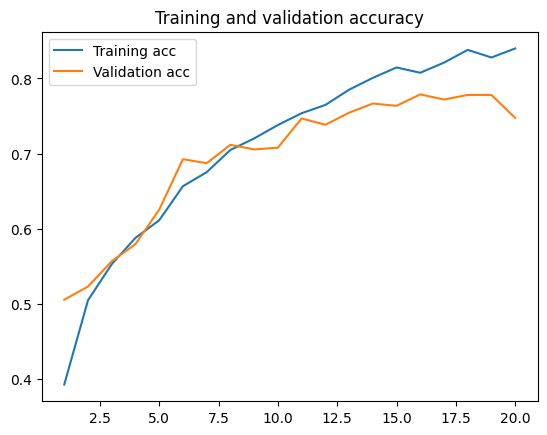

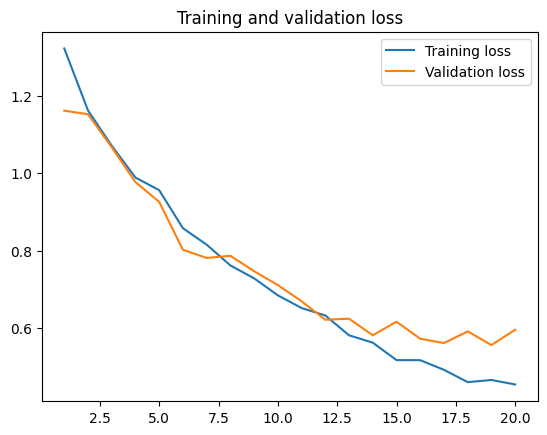

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
